In [1]:
from scipy.integrate import quad as integrate, trapz 
from scipy import interpolate
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
lq = 3
Num = 100_000 # количество генерируемых точек
hxi = 0.01*np.pi # шаг генерации
beta = 0.0276 # температурный делитель
l = 2*np.pi # область генерации начального распределения
n = int(l/hxi)
phix = 0 # 

In [3]:
LL = 10*np.pi # интервал, на котором производится интегрирование
X = np.linspace(-LL/2, LL/2, 10_000)

def fun(x): # функция распределения
    return np.exp((np.cos(x)-1)/beta)*np.exp(-((x-phix)**2)/(2*lq*beta))
part_func = trapz(fun(X), X)
# print('Статсумма = ', part_func, 'в математике получили 6.39276*10^-20 при phix = Pi')

In [4]:
def U(x): 
    return (x-phix)**2/(2*lq) + 1 - np.cos(x)

def coor_destr(x):
    return np.exp(-U(x)/beta)/part_func

xi = np.linspace(-np.pi + phix, np.pi + phix, n)
# применяем определение функции распределения
def prob(xx):
    return integrate(lambda phi: coor_destr(phi), -np.inf, xx)[0]

In [5]:
alpha = []
for xx in xi:
    alpha.append(prob(xx))

inter_func = interpolate.interp1d(alpha, xi)


In [43]:
# параметры
gamma = 0.01 # коэффициент затухания
tau = 1000 # характерное время переключения
T = 1010 # полный интервал времени
dt = 0.1 # шаг по времени
t = np.linspace(0,T, int(T/dt))


In [44]:
def phixx(t): # функция именения параметра управления
    return np.pi*(np.tanh(2*np.pi*t/tau - np.pi)+1) 
    
def H(t, phi, p):
    return p**2/2 + (phi-phixx(t))**2/(2*lq) + 1 - np.cos(phi)

def F(t, phi, p):
    return p, -np.sin(phi) - (phi - phix - np.pi*(np.tanh(2*np.pi*t/tau - np.pi)+1))/lq - gamma*p

100%|████████████████████████████████████████████████████████████████████████████| 10100/10100 [01:42<00:00, 98.67it/s]


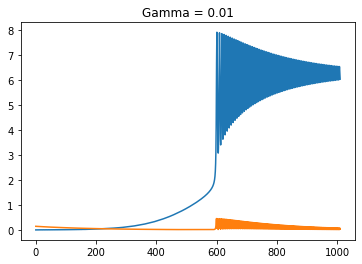

In [45]:
# Выход: mean(t), std(t)
mean = []
std = []
# начальное распределение
np.random.seed(1997)
random_points = np.random.random(Num) # Num случайныйх равномерно распределеных чисел [0,1]
phi_points = inter_func(random_points) # значения phi c требуемым распределением
p_points = np.random.normal(0, np.sqrt(beta), Num)
# главный цикл
for it in tqdm(t):
    k1 = F(it, phi_points, p_points)
    k2 = F(it+dt/2, phi_points + dt*k1[0]/2, p_points + dt*k1[1]/2)
    k3 = F(it+dt/2, phi_points + dt*k2[0]/2, p_points + dt*k2[1]/2)
    k4 = F(it+dt, phi_points + dt*k3[0], p_points + dt*k3[1])
    phi_points = phi_points + dt*(k1[0]+2*k2[0]+2*k3[0]+k4[0])/6
    p_points = p_points + dt*(k1[1]+2*k2[1]+2*k3[1]+k4[1])/6
    mean.append(np.mean(phi_points))
    std.append(np.std(phi_points))

plt.plot(t, mean)
plt.plot(t, std)
plt.title('Gamma = {}'.format(gamma))
plt.show()

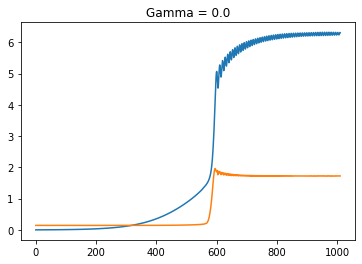

In [30]:
plt.plot(t, mean)
plt.plot(t, std)
plt.title('Gamma = {}'.format(gamma))
plt.show()

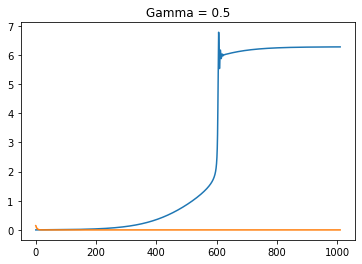

In [34]:
plt.plot(t, mean)
plt.plot(t, std)
plt.title('Gamma = {}'.format(gamma))
plt.show()

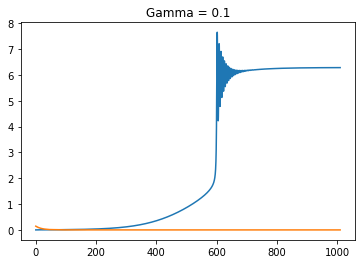

In [38]:
plt.plot(t, mean)
plt.plot(t, std)
plt.title('Gamma = {}'.format(gamma))
plt.show()

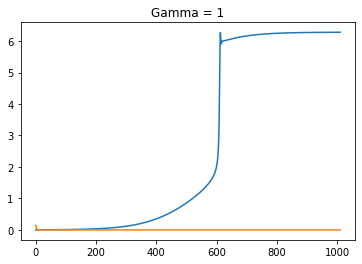

In [42]:
plt.plot(t, mean)
plt.plot(t, std)
plt.title('Gamma = {}'.format(gamma))
plt.show()

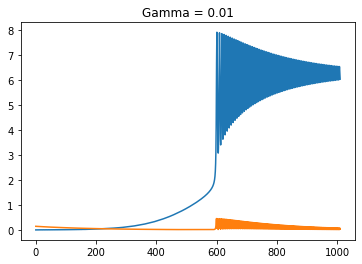

In [46]:
plt.plot(t, mean)
plt.plot(t, std)
plt.title('Gamma = {}'.format(gamma))
plt.show()